In [1]:
# Google Colab
from google.colab import drive
%tensorflow_version 2.x

# System
import sys
import os

%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf

print("Python version :",sys.version)
print("TensorFlow version :",tf.version.VERSION)

devices = tf.config.list_physical_devices()
print(f"\n>> Available devices:\n {devices}")
# beginning /physical_device  is subtracted
GPU, CPU, BESTDEV = None, None, None
for dev in devices:
    if dev.device_type == 'GPU':
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            GPU = '/device:' + name
            print(f"GPU device found: '{GPU}'")
            BESTDEV = GPU
    elif dev.device_type == 'CPU':
            name = dev.name
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            CPU = '/device:' + name
            print(f"CPU device found: '{CPU}'")
if not GPU:
    print("GPU device NOT found")
    BESTDEV = CPU
print(f"Best device is: '{BESTDEV}'")


from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Embedding,GRU,MaxPooling1D,GlobalMaxPooling1D,BatchNormalization

from sklearn.model_selection import train_test_split

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm

import itertools

#mount Google drive
print("Google drive :")
drive.mount("/content/drive",force_remount=True)
PATH_WORK = "/content/drive/MyDrive/Rakuten"

#go to working directory
os.chdir(PATH_WORK)
print("content of CWD :",os.listdir())

data_train = pd.read_csv('X_train_rakuten_afterEDA_preprocessing.csv',index_col=0)
data_train = data_train.reset_index(drop=False)
data_train['nom_img'] = r"/tmp/images/cropped_image_train/" + data_train['nom_img']
data_train.shape

Python version : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow version : 2.6.0

>> Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU device found: '/device:CPU:0'
GPU device found: '/device:GPU:0'
Best device is: '/device:GPU:0'
Google drive :
Mounted at /content/drive
content of CWD : ['X_train_rakuten_afterEDA_preprocessing.csv', 'cropped_image_train.zip', 'Rakuten_multimodal_Xception_embedding-GRU.h5', 'model.png', 'Rakuten_multimodal_best_model_8409_pretrained_VGG16_embedding-GRU.h5']


(84613, 6)

In [2]:
#display columns including product images (nom_img)
data_train.head()


,designation_orig,nom_img,lang_designation,designation,prdtypecode,designation_token_final
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,/tmp/images/cropped_image_train/image_12635970...,de,olivia: notebook personnalise / pages / punks...,10,"['notebook', 'page', 'design']"
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,/tmp/images/cropped_image_train/image_10081412...,fr,journal des art (le) n° du // art et son ma...,2280,"['journal', 'art', 'art', 'marche', 'salon', '..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,/tmp/images/cropped_image_train/image_93877797...,fr,grand stylet ergonomique bleu gamepad nintendo...,50,"['stylet', 'ergonomique', 'gamepad', 'nintendo..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,/tmp/images/cropped_image_train/image_45704749...,fr,peluche donald europe disneyland (marionn...,1280,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques Luc a des idées de grande...,/tmp/images/cropped_image_train/image_10777577...,fr,la guerre des tuques luc a des idees de grande...,2705,"['guerre', 'luc', 'idees', 'grandeur', 'vouloi..."


In [3]:
%%bash

# Images source and destination
SRC="/content/drive/MyDrive/Rakuten/cropped_image_train.zip"
DEST="/tmp/images"


# Check it has not been done
if [ -d "$DEST" ]; then
    echo "Images already unzipped"
else
    # Create directory and unzip all set of images
    mkdir -p "$DEST"
    unzip -q "$SRC" -d "$DEST"
    echo "Images unzipped"
fi

Images unzipped


In [4]:
#delete rows where images are smaller than 2k equal to noise rather than information
from pathlib import Path

list_products_to_be_deleted_due_to_too_small_image = []
nbr_to_be_deleted = 0
for i in range(len(data_train)):
    fname = data_train['nom_img'].iloc[i]
    file_size =Path(fname).stat().st_size
    if (file_size < 2048):
        print("The file {0} has a too small size of {1} bytes ".format(fname,file_size))
        list_products_to_be_deleted_due_to_too_small_image.append(i)
        nbr_to_be_deleted += 1

#rows deletion
print("number of deleted rows due to image size smaller than 2K :",nbr_to_be_deleted)
print("shape before cleaning :",data_train.shape)
data_train = data_train.drop(list_products_to_be_deleted_due_to_too_small_image)
print("new shape of dataset after preprocessing : ", data_train.shape)

The file /tmp/images/cropped_image_train/image_332521213_product_46540267.jpg has a too small size of 1597 bytes 
The file /tmp/images/cropped_image_train/image_1289984514_product_4090784667.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1216298756_product_3479934811.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1026005405_product_558486639.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1252146802_product_3845529844.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1026005681_product_558486488.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1166709808_product_2823853943.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1303170478_product_4157448609.jpg has a too small size of 0 bytes 
The file /tmp/images/cropped_image_train/image_1283323476_product_4061150498.jpg has a too

In [5]:
#cell specific for text preprocessing handled by Neural Network
# column designation_token_final is the result of preprocessing text cleaning (stopwords and so on) under tokens form
# so, we transform it again into text string in designation_str_tokens that is now the features data column
# to prepare the association between each word and a integer number (index in dictionary of full vocabulary describing products)
import re
data_train['designation_str_tokens'] = ""
for i in range(len(data_train)):
    data_train['designation_str_tokens'].iloc[i] += "".join(data_train['designation_token_final'].iloc[i]) 

data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r',', '', x))
data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r"'", '', x))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
#training and validation set , not yet test set 
target = data_train.prdtypecode
X = data_train.designation_token_final
data_train = data_train.drop(['designation_orig','lang_designation','designation','designation_token_final','prdtypecode'],axis=1)

#Divide randomly data into training and validation set
#for image and text handled by DL
X_train, X_test, y_train, y_test = train_test_split(data_train,target, test_size=0.2, random_state=42)

#for text handled by ML algorithms
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, target , test_size=0.2,random_state=42)

#for text handled by DL
df_train = pd.concat([X_train,y_train],axis=1)
df_train = df_train.reset_index(drop=True)
df_test = pd.concat([X_test,y_test],axis=1)
df_test = df_test.reset_index(drop=True)

name_class = ['editions','magazines',"equipement_playstation","jouets_enfant","livres","fournitures_scolaires","materiel_jardin","mobilier_interieur","jeux_enfants","literie","livres_par_lot","figurine","materiel_piscine","univers_de_fiction","equipements_telecommandes","materiel_jeux_video","jeux_de_cartes_collection","decoration","jeux_video","console_de_jeu","materiel_bebe","peche_lampe_plein_air","materiel_animaux_compagnie","jeux_sur_PC","accessoires_outil","articles_nourriture","vetements_nouveau-né_et_billard_flechettes"] 
list_class = [10, 2280 ,  50 ,1280 ,2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300 ,2462, 1160, 2060 , 40,   60 ,1320 ,1302 ,2220 ,2905, 2585, 1940 ,1301]       
list_class_onehot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

# df_train and df_test will be used to build the batchs !!!!!!
df_train['class_onehot']= 0
for i in range(len(df_train)):
    index = list_class.index(df_train['prdtypecode'].iloc[i])
    df_train['class_onehot'].iloc[i] = list_class_onehot[index]

df_test['class_onehot']= 0
for i in range(len(df_test)):
    index = list_class.index(df_test['prdtypecode'].iloc[i])
    df_test['class_onehot'].iloc[i] = list_class_onehot[index]

display(df_train.head(50))

print("\ndimension training set :",df_train.shape)
print("dimension test set :",df_test.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,nom_img,designation_str_tokens,prdtypecode,class_onehot
0,/tmp/images/cropped_image_train/image_90058562...,[taggl jeu carte taggl faire joueur repartir j...,1281,8
1,/tmp/images/cropped_image_train/image_13235048...,[kinder zimmer dekoration brief kissen englisc...,1920,9
2,/tmp/images/cropped_image_train/image_10380934...,[herlitz pochette classement easy orga pastel ...,2522,5
3,/tmp/images/cropped_image_train/image_12428699...,[ici pays quebec milieu xix siecle nombreux pi...,2705,4
4,/tmp/images/cropped_image_train/image_10789720...,[bache bulle bordee ubbink bach bulle piscine ...,2583,12
5,/tmp/images/cropped_image_train/image_11271278...,[baldiflex topper surmatelas mousse memoire fo...,1560,7
6,/tmp/images/cropped_image_train/image_10768806...,[point vue mariage fille duc],2280,1
7,/tmp/images/cropped_image_train/image_13002630...,[rechargeable lipo capacite batterie accessoir...,1300,14
8,/tmp/images/cropped_image_train/image_11582861...,[peluche couverture hercule],1280,3
9,/tmp/images/cropped_image_train/image_13161957...,[retro console jeu poch bit pouce lcd enfant j...,60,19



dimension training set : (67500, 4)
dimension test set : (16876, 4)


In [ ]:
# MODEL 3 : Random Forest based on unigrams and bi-grams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import itertools
import time

# Application TfidfVectorizer
tfvectorizer = TfidfVectorizer(ngram_range=(1,2))

# Entrainement et transformation
X_train_tf = tfvectorizer.fit_transform(X_train_t)
X_test_tf = tfvectorizer.transform(X_test_t)

# Classifier instanciation
clf3 = RandomForestClassifier()

start = time.time()
# Training and prediction
clf3.fit(X_train_tf, y_train_t)
y_pred_clf3 = clf3.predict(X_test_tf)
y_pred_proba_clf3 = clf3.predict_proba(X_test_tf)

end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed:.2f} s')


Temps d'exécution : 3806.82 mn


              precision    recall  f1-score   support

          10       0.41      0.45      0.43       631
          40       0.65      0.60      0.63       465
          50       0.85      0.68      0.76       335
          60       0.92      0.86      0.89       154
        1140       0.71      0.77      0.74       515
        1160       0.66      0.92      0.77       771
        1180       0.74      0.54      0.63       169
        1280       0.70      0.58      0.64       969
        1281       0.74      0.47      0.58       396
        1300       0.81      0.92      0.86       995
        1301       0.97      0.92      0.94       155
        1302       0.89      0.71      0.79       483
        1320       0.82      0.74      0.78       656
        1560       0.75      0.84      0.79      1007
        1920       0.91      0.90      0.91       869
        1940       0.91      0.76      0.82       152
        2060       0.77      0.78      0.77      1018
        2220       0.94    

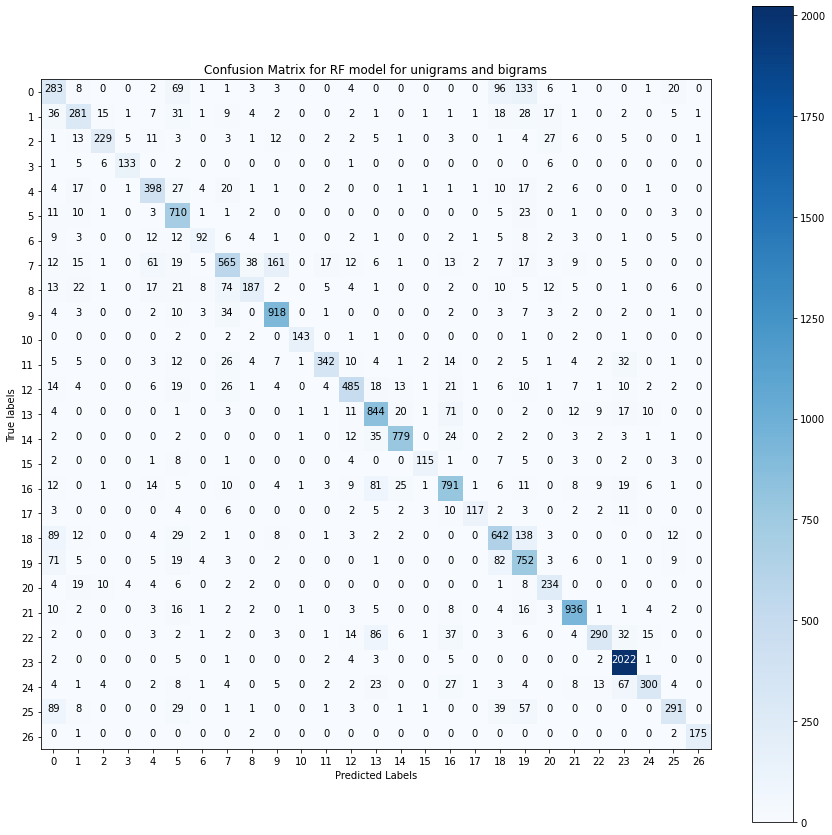

In [ ]:
# RF model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
# Classification Report
print(classification_report(y_test_t, y_pred_clf3))

# Confusion matrix
#pd.crosstab(y_test_t, y_pred_clf3, rownames=['classes réelles'], colnames=['classes prédites'])
import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(y_test_t, y_pred_clf3)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for RF model for unigrams and bigrams")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
# MODEL 3 : Random Forest based on unigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import itertools
import time

# Application TfidfVectorizer
tfvectorizer = TfidfVectorizer(ngram_range=(1,1))

# Entrainement et transformation
X_train_tf = tfvectorizer.fit_transform(X_train_t)
X_test_tf = tfvectorizer.transform(X_test_t)

# Classifier instanciation
clf3 = RandomForestClassifier()

start = time.time()
# Training and prediction
clf3.fit(X_train_tf, y_train_t)
y_pred_clf3 = clf3.predict(X_test_tf)
y_pred_proba_clf3 = clf3.predict_proba(X_test_tf)

end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed:.2f} s')

Temps d'exécution : 516.01 mn


              precision    recall  f1-score   support

          10       0.47      0.39      0.42       631
          40       0.65      0.60      0.62       465
          50       0.83      0.70      0.76       335
          60       0.94      0.84      0.89       154
        1140       0.70      0.77      0.73       515
        1160       0.70      0.90      0.79       771
        1180       0.73      0.56      0.63       169
        1280       0.70      0.59      0.64       969
        1281       0.66      0.48      0.55       396
        1300       0.82      0.93      0.87       995
        1301       0.96      0.92      0.94       155
        1302       0.89      0.74      0.81       483
        1320       0.81      0.73      0.77       656
        1560       0.73      0.83      0.78      1007
        1920       0.91      0.90      0.90       869
        1940       0.89      0.77      0.83       152
        2060       0.78      0.78      0.78      1018
        2220       0.95    

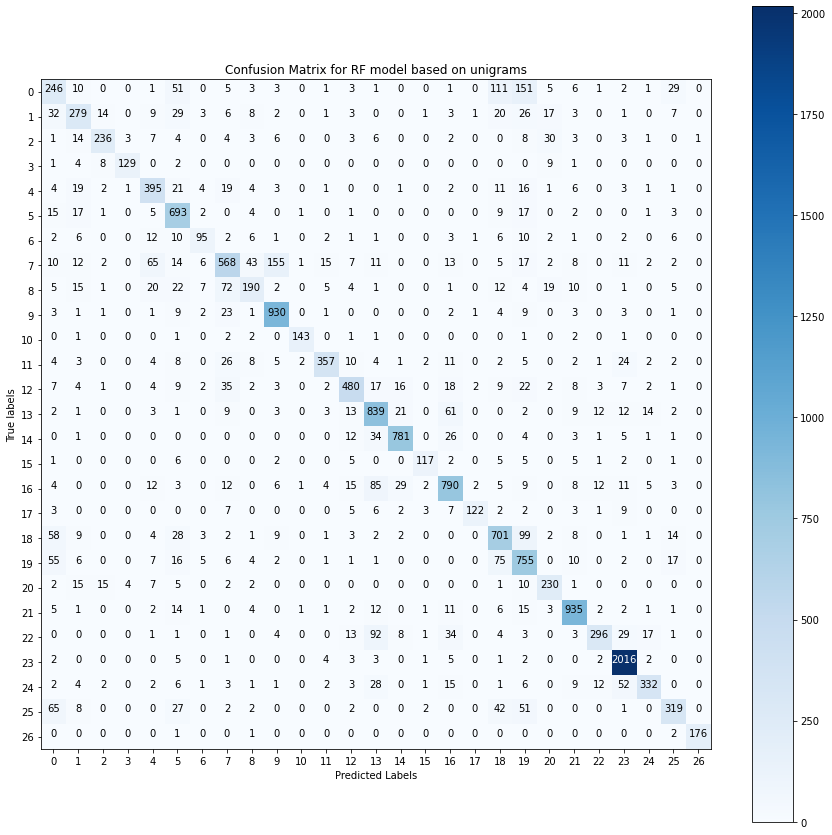

In [ ]:
# RF model evaluation

# Classification Report
print(classification_report(y_test_t, y_pred_clf3))

# Confusion matrix
#pd.crosstab(y_test_t, y_pred_clf3, rownames=['classes réelles'], colnames=['classes prédites'])
import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(y_test_t, y_pred_clf3)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for RF model based on unigrams")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
# MODEL 2 : Support Vectors Classifier based on unigrams AND bi-grams
from sklearn.svm import SVC
# Application TfidfVectorizer
tfvectorizer = TfidfVectorizer(ngram_range=(1,2))

# Entrainement et transformation
X_train_tf = tfvectorizer.fit_transform(X_train_t)
X_test_tf = tfvectorizer.transform(X_test_t)

#Classifier instanciation
clf2 = SVC(probability=True)

# Training and prediction
start = time.time()
clf2.fit(X_train_tf, y_train_t)
y_pred_clf2 = clf2.predict(X_test_tf)
y_pred_proba_clf2 = clf2.predict_proba(X_test_tf)

end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed:.2f} s')

Temps d'exécution : 15483.54 mn


              precision    recall  f1-score   support

          10       0.55      0.42      0.47       631
          40       0.71      0.60      0.65       465
          50       0.78      0.75      0.76       335
          60       0.96      0.82      0.89       154
        1140       0.77      0.77      0.77       515
        1160       0.87      0.88      0.87       771
        1180       0.84      0.50      0.63       169
        1280       0.65      0.62      0.63       969
        1281       0.72      0.48      0.58       396
        1300       0.83      0.94      0.88       995
        1301       0.99      0.92      0.95       155
        1302       0.89      0.78      0.83       483
        1320       0.86      0.78      0.82       656
        1560       0.75      0.85      0.80      1007
        1920       0.90      0.92      0.91       869
        1940       0.95      0.76      0.84       152
        2060       0.81      0.80      0.81      1018
        2220       0.84    

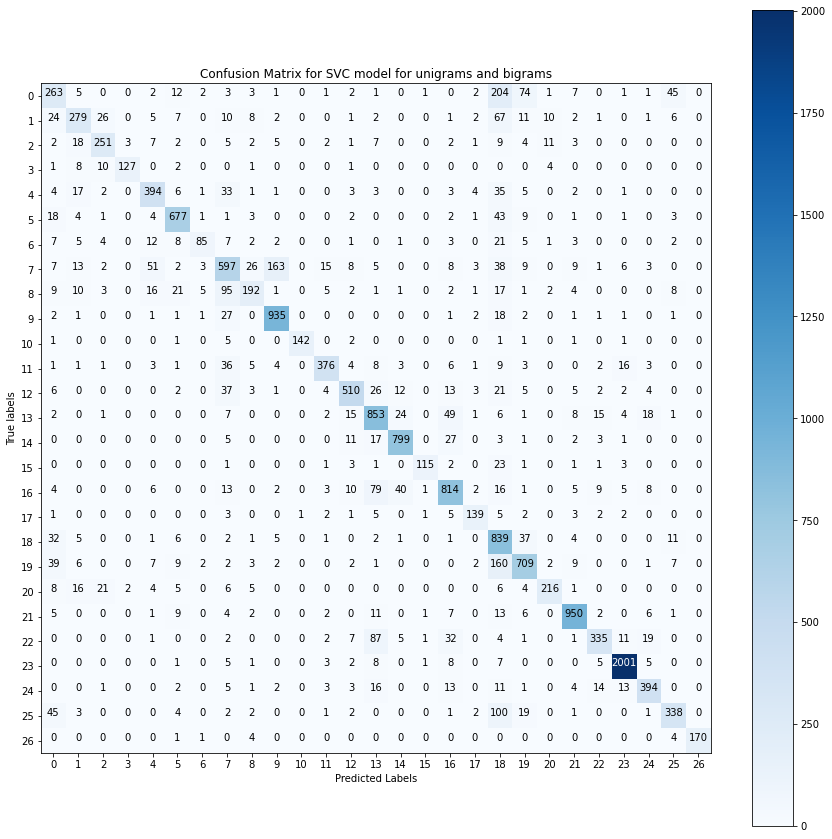

In [ ]:
# SVC model evaluation

# Classification Report
print(classification_report(y_test_t, y_pred_clf2))

# Confusion matrix
#pd.crosstab(y_test_t, y_pred_clf2, rownames=['classes réelles'], colnames=['classes prédites'])
import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(y_test_t, y_pred_clf2)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for SVC model for unigrams and bigrams")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()



In [8]:
# MODEL 2 : Support Vectors Classifier based on unigrams

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import time
# Application TfidfVectorizer
tfvectorizer = TfidfVectorizer(ngram_range=(1,1))

# Entrainement et transformation
X_train_tf = tfvectorizer.fit_transform(X_train_t)
X_test_tf = tfvectorizer.transform(X_test_t)

#Classifier instanciation
clf2 = SVC(probability=True)

# Training and prediction
start = time.time()
clf2.fit(X_train_tf, y_train_t)
y_pred_clf2 = clf2.predict(X_test_tf)
y_pred_proba_clf2 = clf2.predict_proba(X_test_tf)

end = time.time()
elapsed = end - start
print(f'Temps d\'exécution : {elapsed:.2f} s')

Temps d'exécution : 6449.44 s


              precision    recall  f1-score   support

          10       0.49      0.54      0.51       631
          40       0.69      0.64      0.67       465
          50       0.80      0.76      0.78       335
          60       0.96      0.82      0.89       154
        1140       0.77      0.78      0.78       515
        1160       0.87      0.90      0.89       771
        1180       0.85      0.51      0.64       169
        1280       0.68      0.65      0.66       969
        1281       0.73      0.50      0.59       396
        1300       0.86      0.94      0.90       995
        1301       0.99      0.93      0.96       155
        1302       0.89      0.80      0.84       483
        1320       0.87      0.81      0.84       656
        1560       0.79      0.83      0.81      1007
        1920       0.90      0.92      0.91       869
        1940       0.94      0.79      0.86       152
        2060       0.83      0.79      0.81      1018
        2220       0.86    

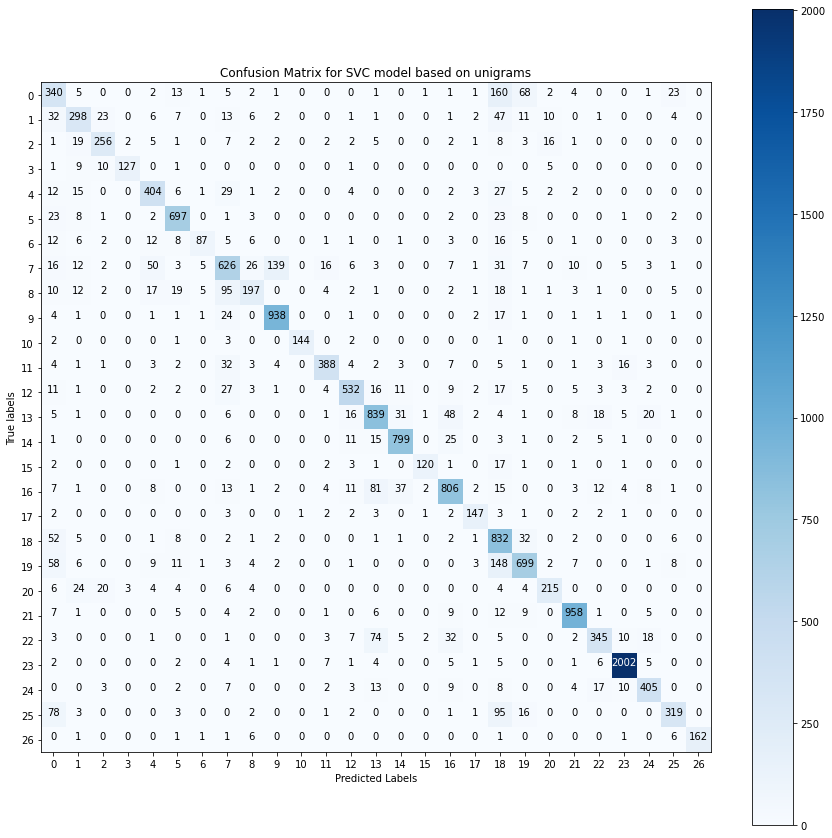

In [9]:
# SVC model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
# Classification Report
print(classification_report(y_test_t, y_pred_clf2))

# Confusion matrix
#pd.crosstab(y_test_t, y_pred_clf2, rownames=['classes réelles'], colnames=['classes prédites'])
import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(y_test_t, y_pred_clf2)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for SVC model based on unigrams")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()


In [10]:
# import libraries
# for Naive Bayes model prediction study on with n-grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

# train model with different n-gram ranges

for N in range(1,5):
    # convert training data to bag of words
    cv = CountVectorizer(analyzer = 'word',ngram_range=(1,N))

    X_train_cv = cv.fit_transform(X_train_t)
    X_test_cv = cv.transform(X_test_t)

    # train model and generate predictions
    clf = MultinomialNB()
    clf.fit(X_train_cv, y_train_t)
    y_pred = clf.predict(X_test_cv)

    # compute f-1 score
    score = np.round(f1_score(y_test_t, y_pred, average='weighted'),2)
    print('F1 score of model with n-gram range of {}: {}'.format((1,N), score))

F1 score of model with n-gram range of (1, 1): 0.75
F1 score of model with n-gram range of (1, 2): 0.72
F1 score of model with n-gram range of (1, 3): 0.71
F1 score of model with n-gram range of (1, 4): 0.71


In [11]:
# convert training data to bag of words
cv = CountVectorizer(analyzer = 'word',ngram_range=(2,2))

X_train_cv = cv.fit_transform(X_train_t)
X_test_cv = cv.transform(X_test_t)

# train model and generate predictions
clf = MultinomialNB()
clf.fit(X_train_cv, y_train_t)
y_pred = clf.predict(X_test_cv)

# compute f-1 score
score = np.round(f1_score(y_test_t, y_pred, average='weighted'),2)
print('F1 score of model with n-gram range of {}: {}'.format((2,2), score))

F1 score of model with n-gram range of (2, 2): 0.69
